In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn

import torch.optim as optim

from copy import deepcopy

from torch.distributions import Categorical, Normal

import itertools

import sys
sys.path.insert(0, './../libraries/')

import importance_sample_lib as imp_lib
import galaxy_experiments_lib as galaxy_lib

import sys
sys.path.insert(0, '../../../celeste_net/')
import celeste_net 

from celeste_net import OneGalaxyVAE


from datasets import Synthetic

# Load data

In [2]:
side_len = 31

In [3]:
galaxy_data = Synthetic(side_len, min_galaxies=3, max_galaxies=3, num_bands=5,
                        num_images=100, brightness = 5000)

In [4]:
train_loader, test_loader = galaxy_lib.get_train_test_data(galaxy_data, batch_size=10)

In [5]:
for batch_idx, data in enumerate(train_loader):
    train_data_batch1 = data
    break
    
images_batch1 = train_data_batch1['image']
backgrounds_batch1 = train_data_batch1['background']

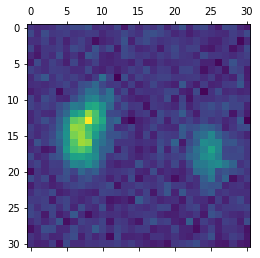

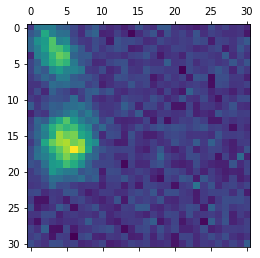

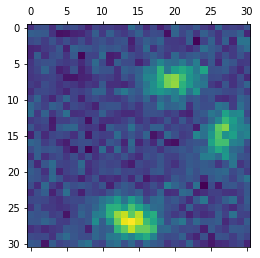

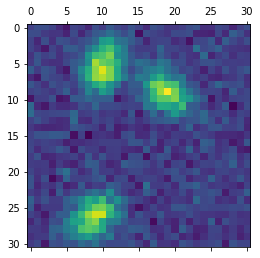

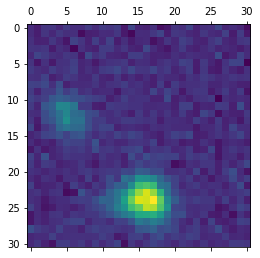

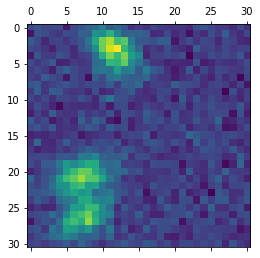

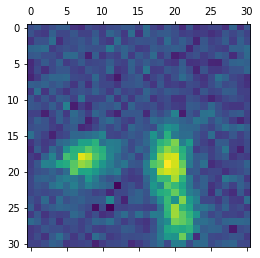

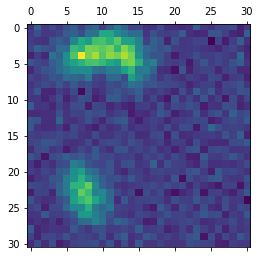

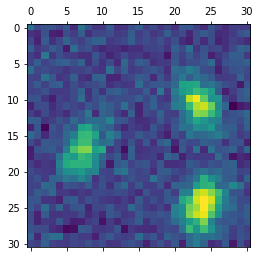

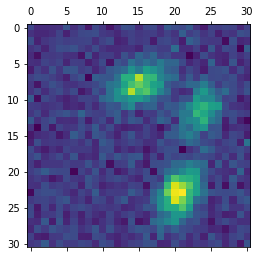

In [6]:
for i in range(images_batch1.shape[0]): 
    plt.matshow(images_batch1[i, 0, :, :])

In [7]:
# The VAE
galaxy_vae = celeste_net.OneGalaxyVAE(side_len)

In [8]:
galaxy_rnn = galaxy_lib.CelesteRNN(side_len, one_galaxy_vae=galaxy_vae)

In [9]:
state_dict = torch.load('../galaxy_results/multiple_detections/galaxy_vae_3detections_imp_sample_off_epoch30.dat', map_location='cpu')
galaxy_rnn.load_state_dict(state_dict, strict = True)

In [10]:
galaxy_rnn.eval(); 
galaxy_rnn.one_galaxy_vae.eval(); 

In [11]:
_, loss = galaxy_rnn.get_pm_loss(image = images_batch1, 
                                    image_so_far = backgrounds_batch1, 
                                    var_so_far = backgrounds_batch1, 
                                    alpha = 0.0, 
                                    topk = 0, 
                                    use_baseline = False)

print(loss)

tensor(1.00000e+05 *
       1.1185)


In [12]:
galaxy_lib.train_epoch(galaxy_rnn, train_loader,
            alpha = 0.0,
            topk = 0,
            use_baseline = False,
            train = False)

tensor(1.00000e+05 *
       1.0657)

In [14]:
pixel_probs = galaxy_rnn.get_pixel_probs(resid_image = images_batch1 - backgrounds_batch1, 
                                         var_so_far = backgrounds_batch1)

In [15]:
torch.max(pixel_probs, dim = 1)

(tensor([ 0.2011,  0.1798,  0.2210,  0.1547,  0.4103,  0.2703,  0.2574,
          0.3835,  0.2103,  0.2356]),
 tensor([ 256,  300,  516,  511,  472,    8,  337,    4,  480,  453]))

In [16]:
prob_off = pixel_probs.detach()[:, -1].view(-1, 1)

prob off:  [1.0517571e-16]


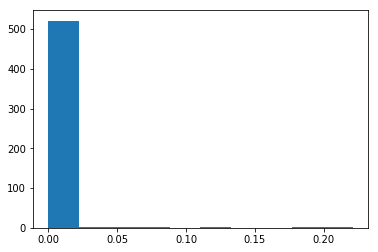

In [17]:
n = 2
plt.hist(pixel_probs[n, :].detach()); 
print('prob off: ', prob_off[n].detach().numpy())

In [18]:
attn_offset = galaxy_rnn.attn_offset

importance_weights = \
    imp_lib.get_importance_weights(torch.abs(images_batch1 - backgrounds_batch1), attn_offset, prob_off)

prob off:  [1.0517571e-16]


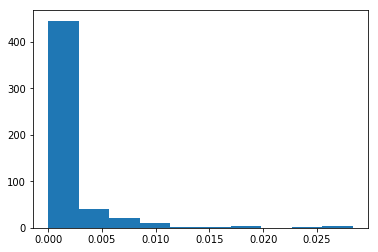

In [19]:
plt.hist(importance_weights[n, :]); 
print('prob off: ', prob_off[n].detach().numpy())

In [23]:
_, loss, recon_means = imp_lib.get_importance_sampled_galaxy_loss(galaxy_rnn, images_batch1, backgrounds_batch1,
                                    use_importance_sample = False,
                                    use_baseline = False,
                                    max_detections = 3)

tensor([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])
tensor([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])
tensor([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])
torch.Size([10])
torch.Size([10])
torch.Size([10])


In [25]:
loss

tensor(46091.2422)

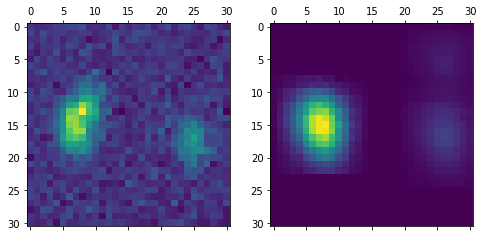

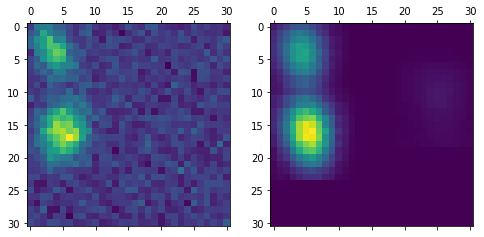

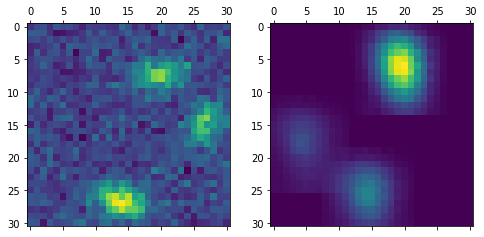

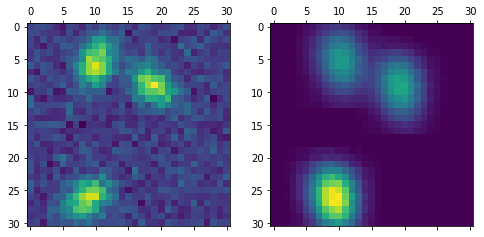

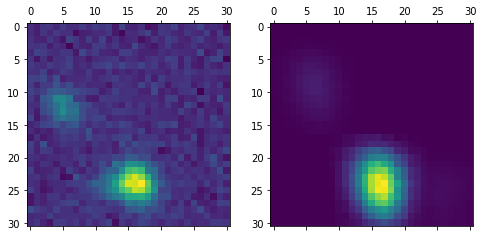

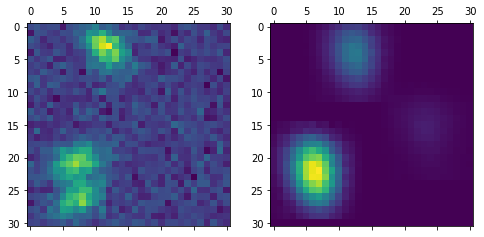

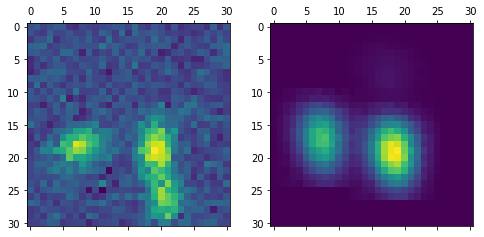

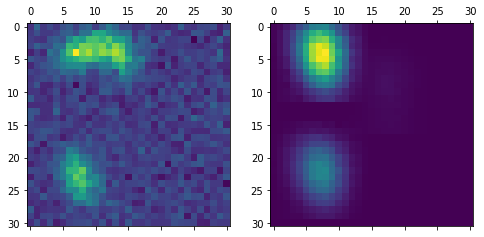

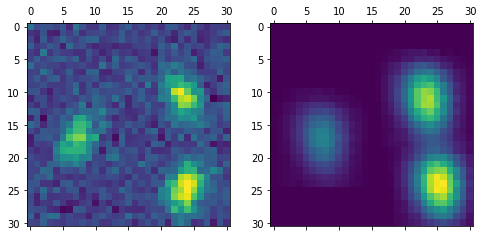

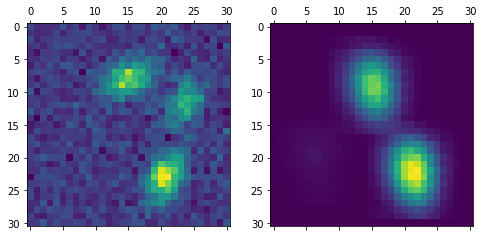

In [26]:
figsize = 8

for n in range(images_batch1.shape[0]): 
    f, axarr = plt.subplots(1, 2, figsize=(figsize, figsize))

    axarr[0].matshow(images_batch1[n, 0, :, :].squeeze())
    axarr[1].matshow(recon_means.detach()[n, 0, :, :].squeeze())


In [45]:
loss_array_imp_sample = np.load('../galaxy_results/multiple_detections/galaxy_vae_batch_losses_array.npy')
loss_array_default = np.load('../galaxy_results/multiple_detections/galaxy_vae_imp_sampl_off_batch_losses_array.npy')

In [46]:
fontsize = 18

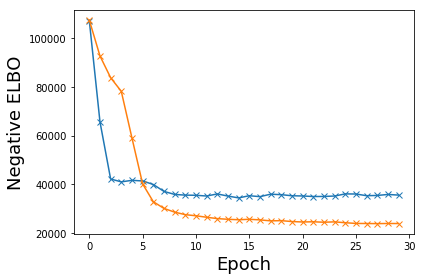

In [47]:
plt.plot(loss_array_imp_sample, '-x')
plt.plot(loss_array_default, '-x')

plt.xlabel('Epoch', fontsize = fontsize)
plt.ylabel('Negative ELBO', fontsize = fontsize)
# plt.legend(('REINFORCE + CV', 'Rao-Blackwellized'))
plt.tight_layout()